In [1]:
%matplotlib inline
import sklearn
from sklearn import manifold
from sklearn import datasets
from sklearn.utils.extmath import safe_sparse_dot
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.metrics import pairwise_distances_argmin
import math
import pandas as pd
import random
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import os
from scipy.spatial import distance
pd.__version__
matplotlib.__version__
np.__version__
sklearn.__version__

C:\Users\Florian\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


'0.23.2'

In [2]:
pwd

'C:\\Users\\Florian\\Desktop\\github\\BMA-StrategyDevelopment\\external_analysis'

In [3]:
ls

 Volume in Laufwerk C: hat keine Bezeichnung.
 Volumeseriennummer: 7275-40B4

 Verzeichnis von C:\Users\Florian\Desktop\github\BMA-StrategyDevelopment\external_analysis

22.10.2021  15:40    <DIR>          .
22.10.2021  15:40    <DIR>          ..
22.09.2021  11:28    <DIR>          .ipynb_checkpoints
23.10.2021  00:57    <DIR>          clustering
22.10.2021  15:40           418.765 comparisonDistanceMesasure.ipynb
28.08.2021  09:42            13.796 ellbowcurve.pdf
27.08.2021  23:46            13.291 ellbowcurve_across_distances.pdf
27.08.2021  23:46            14.578 ellbowcurve_across_distances_normalized_later.pdf
27.08.2021  23:46            14.490 ellbowcurve_across_distances_standartizised.pdf
27.08.2021  23:46            14.515 euclidean_inertia_across_distances.pdf
22.10.2021  15:40            95.755 init_prob.ipynb
22.10.2021  15:38            13.090 initialise_problem.pdf
12.08.2021  12:53            55.756 mdsPythonSkLearnWikiDistanceMatrix.ipynb
15.07.2021  19:15           

In [4]:
parentDir = "results"
if not os.path.exists(parentDir):
    os.mkdir(parentDir)

In [5]:
df = pd.read_excel(open('strategiebuendel_5_5.xlsx','rb'), skiprows=[0,2], header=[0], sheet_name=0, index_col=[0])
# df = pd.read_excel(open('strategiebuendel_custom.xlsx','rb'), skiprows=[0,2], header=[0], sheet_name=0, index_col=[0])
# df = pd.read_excel(open('strategiebuendel_custom.xlsx','rb'), skiprows=[0,2], header=[0], sheet_name=0, index_col=[0])[:2]
df = df.T #[:100]
df.head(5)

Paare,1A/2A,1A/2B,1A/2C,1A/2D,1A/2E,1A/3A,1A/3B,1A/3C,1A/3D,1A/3E,...,4D/5A,4D/5B,4D/5C,4D/5D,4D/5E,4E/5A,4E/5B,4E/5C,4E/5D,4E/5E
bundle 2435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bundle 2310,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bundle 60,5,0,0,0,0,0,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
bundle 2440,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,0
bundle 3065,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,0,0,0,0,0


In [6]:
df.values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 3, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 2, 0]], dtype=int64)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2760 entries, bundle 2435 to bundle 548
Columns: 250 entries, 1A/2A to 4E/5E
dtypes: int64(250)
memory usage: 5.3+ MB


In [8]:
embedding_df = manifold.MDS(n_components=2, \
                         metric=True, \
                         n_init=1, \
                         max_iter=1, \
                         eps=1e-12, \
                         n_jobs=None, \
                         random_state=0, \
                         dissimilarity="euclidean")
data_transformed_df = embedding_df.fit_transform(df.values)
data_transformed_df.shape

(2760, 2)

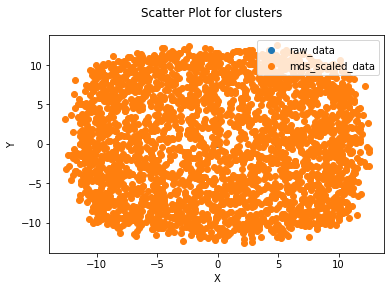

In [9]:
fig = plt.figure()
fig.suptitle('Scatter Plot for clusters')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.scatter(df.values[:,0],df.values[:,1], cmap='viridis', label="raw_data")
ax.scatter(data_transformed_df[:,0],data_transformed_df[:,1], cmap='viridis', label="mds_scaled_data")
plt.legend(loc="upper right")

In [10]:
def get_inertia(vectors_of_all_centroids, data, labels, distance_function):
    totaldistance = 0
    for a in range(len(data)):
        localdistance = distance_function(data[a], vectors_of_all_centroids[labels[a]])
        totaldistance += localdistance
    return totaldistance

In [11]:
def custom_pairwise_distances_argmin(data, centroids, tolerance, distance_function):
    resultIndices = []
    for aIndex in range(len(data)):
        currentMinDistance = round(distance_function(data[aIndex],centroids[0]),tolerance)
        currentMinDistanceIndex = 0
        for bIndex in range(len(centroids)):
            distance = round(distance_function(data[aIndex],centroids[bIndex]),tolerance)
            if(distance < currentMinDistance):
                currentMinDistance = distance
                currentMinDistanceIndex = bIndex
        resultIndices.append(currentMinDistanceIndex)
    return resultIndices

In [12]:
def euclidean_distance(vector_0, vector_1):
    total = 0
    diff = 0
    for a in range(len(vector_0)):
        diff = vector_1[a] - vector_0[a]
        total = total + diff * diff
    return math.sqrt(total)

In [13]:
def squared_euclidean_distance(vector_0, vector_1):
    total = 0
    diff = 0
    for a in range(len(vector_0)):
        diff = vector_1[a] - vector_0[a]
        total = total + diff * diff
    return total

In [14]:
def chebyshev_distance(vector_0, vector_1):
    currentMaxResult = abs(vector_1[0] - vector_0[0])
    for a in range(1,len(vector_1)):
        tmpResult = abs(vector_1[a] - vector_0[a])
        if(currentMaxResult < tmpResult):
            currentMaxResult = tmpResult
    return currentMaxResult

In [15]:
def manhatten_distance(vector_0, vector_1):
    total = 0
    diff = 0
    for a in range(len(vector_0)):
        diff = abs(vector_0[a] - vector_1[a])
        total = total + diff
    return total

In [16]:
# removed since semanticly not relevant according to current understanding
#
# def hamming_distance(vector_0, vector_1):
#     dist_counter = 0
#     for n in range(len(vector_0)):
#         if vector_0[n] != vector_1[n]:
#             dist_counter += 1
#     return dist_counter

In [17]:
def custom_mean(vectors):
    dimensions = len(vectors[0])
    vector_elements = len(vectors)
    aggregate_vector = [0 for a in range(dimensions)]
    for a in range(vector_elements):
        for b in range(dimensions):
            aggregate_vector[b] += vectors[a][b]
    return [1.0 * a / vector_elements for a in aggregate_vector]

In [18]:
def generateRandomIndices(clusterNumber, minValue, maxValue):
    randomIndices = []
    indexDatapointWhichCentroidWillUse = -1;
    bias = 0;
    for a in range(0,clusterNumber):
        while(True):
            indexDatapointWhichCentroidWillUse = random.randint(minValue, maxValue-1)
            if(indexDatapointWhichCentroidWillUse not in randomIndices):
                break;
        randomIndices.append(indexDatapointWhichCentroidWillUse)
    return randomIndices

In [19]:
def arraysEqual(arr0, arr1, tolerance):
    lenArrAxis0 = len(arr0)
    lenArrAxis1 = len(arr1[0])
    for a in range(0, lenArrAxis0):
        for b in range(0, lenArrAxis1):
            if(round(arr0[a][b], tolerance) != round(arr1[a][b], tolerance)):
                return False
    return True

In [20]:
def calc_kmeans(data, n_clusters, tolerance, distance_function):
    if(len(data) < n_clusters):
        print("cannot request more cluster than data-points you have.")
        return
    random.seed(0)
    randomIndices = generateRandomIndices(n_clusters, 0, len(data))
    centroids = [data[x] for x in randomIndices]
    iterations = 0
    labels = []
    while True:
        iterations+=1
        labels = custom_pairwise_distances_argmin(data, centroids, tolerance, distance_function)
        new_centers = []
        for i in range(n_clusters):
            # fixed but plots are still on old cluster result
            i_center_datapoints_indices = [index for index, a in enumerate(labels) if a ==i]
            if(len(i_center_datapoints_indices) == 0):
                new_centers.append(centroids[i])
            else:
                i_center_datapoints = data[i_center_datapoints_indices]
                i_center = custom_mean(i_center_datapoints)
                new_centers.append(i_center)
        if (arraysEqual(centroids, new_centers, tolerance)): #np.all(centroids == np_new_centers): # np.allclose(centroids, np_new_centers, rtol=0, atol=pow(0.1, tolerance)): #
            break
        centroids = new_centers
    return np.array(labels), np.array(centroids), [get_inertia(centroids,data, labels, euclidean_distance), get_inertia(centroids,data, labels, distance_function)], iterations, n_clusters

In [21]:
clusterNumber = 10
distanceFunction_list = [euclidean_distance, squared_euclidean_distance, chebyshev_distance, manhatten_distance] # , distance.chebyshev, distance.cityblock
clusterList = [a for a in range(1,clusterNumber+1)]

distanceFunctionClusterResult = []
for a in distanceFunction_list:
    clusterResultStoreTmp = []
    for b in clusterList:
        print(b)
        kmeansResult = calc_kmeans(df.values, b, 2, a)
        clusterResultStoreTmp.append({
            "labels": kmeansResult[0],
            "centroids": kmeansResult[1],
            "inertia_euclidean": kmeansResult[2][0],
            "inertia": kmeansResult[2][1],
            "iterations": kmeansResult[3],
            "numberClusters": kmeansResult[4]
        })
    distanceFunctionClusterResult.append(clusterResultStoreTmp)

1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10


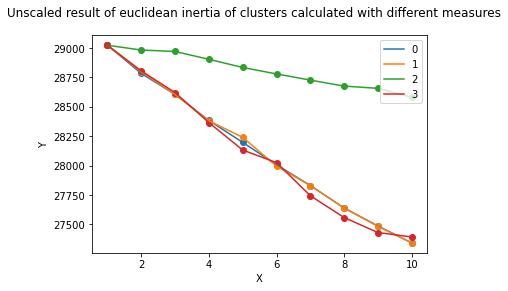

In [22]:
df_tmp = pd.DataFrame({"clusterList": clusterList})

fig = plt.figure()
fig.suptitle('Unscaled result of euclidean inertia of clusters calculated with different measures')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
for aIndex, a in enumerate(distanceFunctionClusterResult):
    y = [b["inertia_euclidean"] for b in a]
    
    df_tmp = df_tmp.join(pd.DataFrame({"function_" + distanceFunction_list[aIndex].__name__ + "_y": y}))
    
    ax.scatter(clusterList,y)
    plt.plot(clusterList, y, label=aIndex)
    plt.legend(loc="upper right")
plt.savefig('euclidean_inertia_across_distances.pdf')
df_tmp.to_csv(parentDir + "/euclideanInertiaResultIndividualMeasures.csv", sep="\t", encoding="utf-8")

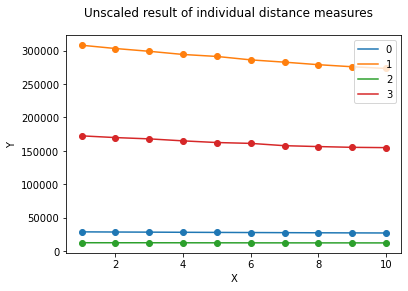

In [23]:
fig = plt.figure()
fig.suptitle('Unscaled result of individual distance measures')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
for aIndex, a in enumerate(distanceFunctionClusterResult):
    y = [b["inertia"] for b in a]
    ax.scatter(clusterList, y)
    plt.plot(clusterList, y, label=aIndex)
    plt.legend(loc="upper right")
plt.savefig('ellbowcurve_across_distances.pdf')

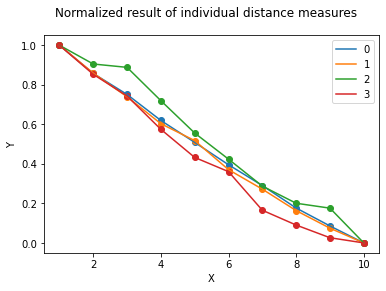

In [24]:
df_tmp = pd.DataFrame({"clusterList": clusterList})

fig = plt.figure()
fig.suptitle('Normalized result of individual distance measures')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
for aIndex, a in enumerate(distanceFunctionClusterResult):
    # min-max-normalization (and not z-score normalization) taken since, the problem of
    # mix-max-normaliztion, namly outlier-issue, is not imprtant here (since
    # normalization takes place across all clusterResults of one distance functon and therefore
    # there likely is no outlierr)
    scaler = MinMaxScaler(feature_range=(0,1))
    dataTmp = np.array([b["inertia"] for b in a]).reshape(-1,1)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(dataTmp)
    normalizedData = scaler.transform(dataTmp)
    normalizedDataNumpy = np.array(normalizedData).reshape(-1)
    
    df_tmp = df_tmp.join(pd.DataFrame({"function_" + distanceFunction_list[aIndex].__name__ + "_y": normalizedDataNumpy}))
    
    ax.scatter(clusterList,normalizedData)
    plt.plot(clusterList,normalizedData, label=aIndex)
    plt.legend(loc="upper right")
plt.savefig('ellbowcurve_across_distances_normalized_later.pdf')
df_tmp.to_csv(parentDir + "/normalizedResultIndividualMeasures.csv", sep="\t", encoding="utf-8")

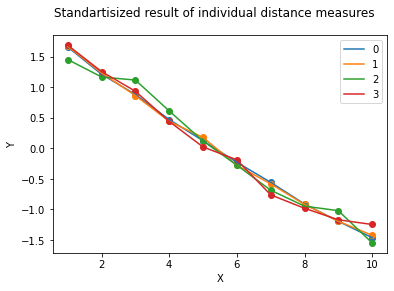

In [25]:
df_tmp = pd.DataFrame({"clusterList": clusterList})

fig = plt.figure()
fig.suptitle('Standartisized result of individual distance measures')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
for aIndex, a in enumerate(distanceFunctionClusterResult):
    # min-max-normalization (and not z-score normalization) taken since, the problem of
    # mix-max-normaliztion, namly outlier-issue, is not imprtant here (since
    # normalization takes place across all clusterResults of one distance functon and therefore
    # there likely is no outlierr)
    scaler = StandardScaler()
    dataTmp = np.array([b["inertia"] for b in a]).reshape(-1,1)
    scaler.fit(dataTmp)
    normalizedData = scaler.transform(dataTmp)
    normalizedDataNumpy = np.array(normalizedData).reshape(-1)
    
    df_tmp = df_tmp.join(pd.DataFrame({"function_" + distanceFunction_list[aIndex].__name__ + "_y": normalizedDataNumpy}))
    
    ax.scatter(clusterList,normalizedData)
    plt.plot(clusterList,normalizedData, label=aIndex)
    plt.legend(loc="upper right")
plt.savefig('ellbowcurve_across_distances_normalized_later.pdf')
df_tmp.to_csv(parentDir + "/standartisizedResultsIndividualMeasures.csv", sep="\t", encoding="utf-8")

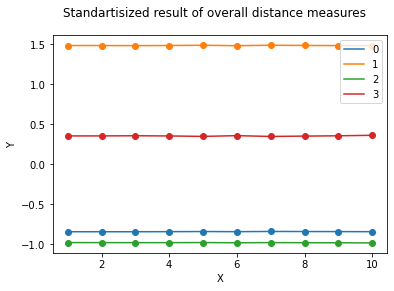

In [26]:
data_single_standardization = []
for a in distanceFunctionClusterResult:
    data_single_standardization.append([b["inertia"] for b in a])
data_single_standardization = np.array(data_single_standardization)

scaler = StandardScaler()
scaler.fit(data_single_standardization)
normalizedData = scaler.transform(data_single_standardization)

fig = plt.figure()
fig.suptitle('Standartisized result of overall distance measures')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
for aIndex, a in enumerate(distanceFunctionClusterResult):
    # min-max-normalization (and not z-score normalization) taken since, the problem of
    # mix-max-normaliztion, namly outlier-issue, is not imprtant here (since
    # normalization takes place across all clusterResults of one distance functon and therefore
    # there likely is no outlierr)
    scaler = StandardScaler()
    dataTmp = normalizedData[aIndex] #.reshape(-1,1)
    ax.scatter(clusterList,dataTmp)
    plt.plot(clusterList,dataTmp, label=aIndex)
    plt.legend(loc="upper right")
plt.savefig('ellbowcurve_across_distances_standartizised.pdf')

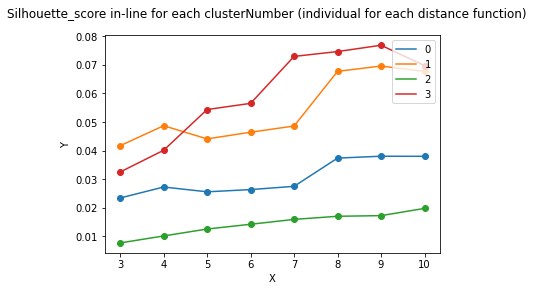

In [27]:
# 1 bedeutet, dass der Datenpunkt den anderen Punkten im Cluster ähnlich ist,
# bei -1 genau das Gegenteil. Das heiß, wenn das Score näher bei -1 ist, dann gibt es
# viele Punkte, die eigentlich nicht in das jeweilige Cluster gehören, dann haben wir
# entwerder zuviele, oder zuwenige Cluster. Man muß den Cluster - Algorithmus noch
# einmal laufen lassen, um die optimale Anzahl an Clustern zu finden.
# https://biteye.at/PythonWeb/kunstliche-intelligenz-und-datamining/9-entscheidungsmuster-mit-unbeaufsichtigtem-lernen/9-2-abschatzung-der-qualitat-des-clusterns-mit-silhouette-scores.html


# centroids_tmp = [b["centroids"] for b in distanceFunctionClusterResult[0]]
# print(centroids_tmp)
# labels_tmp = [b["labels"] for b in distanceFunctionClusterResult[0]]
# print(labels_tmp)

clusterListNumpy = np.array(clusterList)
# needed > 2 since following loop will only consider values with a clusterNumber > 2 (= with over 2 clusters existing)
# reason: you need at least 3 clusters to calculate
df_tmp = pd.DataFrame({"clusterList": clusterListNumpy[clusterListNumpy > 2]})

fig = plt.figure()
fig.suptitle('Silhouette_score in-line for each clusterNumber (individual for each distance function)')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')

for aIndex, a in enumerate(distanceFunctionClusterResult):
    score_all_clusternumbers_per_distance_function = []
    cluster_number_store = []
    for b in a:
        if(b["numberClusters"]>2):
#             print("iteration")
#             print(b["numberClusters"])
#             print(b["labels"])
            score_all_clusternumbers_per_distance_function.append(metrics.silhouette_score(df.values, b["labels"]  , metric=distanceFunction_list[aIndex], sample_size=len(df.values)))
            cluster_number_store.append(b["numberClusters"])
    
    silhouetteScoreNumpy = np.array(score_all_clusternumbers_per_distance_function)
    df_tmp = df_tmp.join(pd.DataFrame({"function_" + distanceFunction_list[aIndex].__name__ + "_y": silhouetteScoreNumpy}))
    
    ax.scatter(cluster_number_store,score_all_clusternumbers_per_distance_function)
    plt.plot(cluster_number_store,score_all_clusternumbers_per_distance_function, label=aIndex)
    plt.legend(loc="upper right")
df_tmp.to_csv(parentDir + "/silhouetteScoreResultsIndividualMeasures.csv", sep="\t", encoding="utf-8")

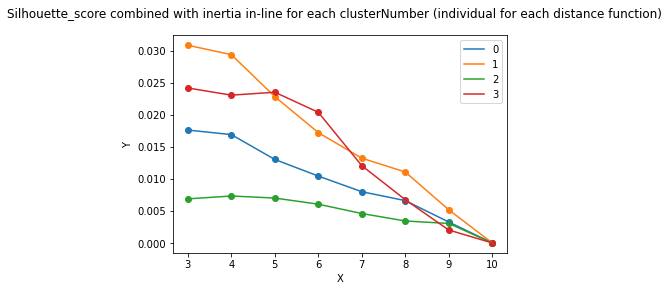

In [28]:
# silhouette combines with inertia

clusterListNumpy = np.array(clusterList)
# needed > 2 since following loop will only consider values with a clusterNumber > 2 (= with over 2 clusters existing)
# reason: you need at least 3 clusters to calculate
df_tmp = pd.DataFrame({"clusterList": clusterListNumpy[clusterListNumpy > 2]})

fig = plt.figure()
fig.suptitle('Silhouette_score combined with inertia in-line for each clusterNumber (individual for each distance function)')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')

for aIndex, a in enumerate(distanceFunctionClusterResult):
    inertia_silhouette = []
    cluster_number_store = []
    
    scaler = MinMaxScaler(feature_range=(0,1))
    dataTmp = np.array([b["inertia"] for b in a]).reshape(-1,1)
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(dataTmp)
    normalizedData = scaler.transform(dataTmp)
    
    
    for bIndex, b in enumerate(a):
        if(b["numberClusters"]>2):
            score_silhouette = metrics.silhouette_score(df.values, b["labels"]  , metric=distanceFunction_list[aIndex], sample_size=len(df.values))
            result = score_silhouette * normalizedData[bIndex]
            inertia_silhouette.append(result)
            cluster_number_store.append(b["numberClusters"])
    
    inertia_silhouette_numpy = np.array(inertia_silhouette).reshape(-1)
    df_tmp = df_tmp.join(pd.DataFrame({"function_" + distanceFunction_list[aIndex].__name__ + "_y": inertia_silhouette_numpy}))
    
    ax.scatter(cluster_number_store,inertia_silhouette)
    plt.plot(cluster_number_store,inertia_silhouette, label=aIndex)
    plt.legend(loc="upper right")
df_tmp.to_csv(parentDir + "/silhouetteScoreWithInertiaResultsIndividualMeasures.csv", sep="\t", encoding="utf-8")

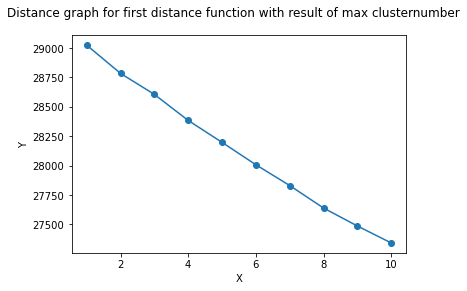

In [36]:
# take results of first distance function for example
clusterResultStore = distanceFunctionClusterResult[0]
# take result of clusterResultStore with max cluster being used
clusterResult = clusterResultStore[len(clusterResultStore)-1]
inertia = [a["inertia"] for a in clusterResultStore]

df_tmp = pd.DataFrame({"clusterList": np.array(clusterList), "function_" + distanceFunction_list[aIndex].__name__ + "_y": np.array(inertia)})
df_tmp.to_csv(parentDir + "/euclideanInertiaResults.csv", sep="\t", encoding="utf-8")

fig = plt.figure()
fig.suptitle('Distance graph for first distance function with result of max clusternumber')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.scatter(clusterList,inertia)
plt.plot(clusterList, inertia)
plt.savefig('ellbowcurve.pdf')

(2760, 2)


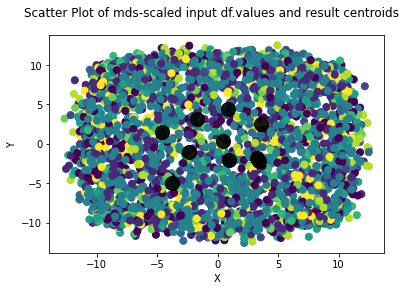

In [30]:
embedding = manifold.MDS(n_components=2, \
                         metric=True, \
                         n_init=1, \
                         max_iter=1, \
                         eps=1e-12, \
                         n_jobs=None, \
                         random_state=0, \
                         dissimilarity="euclidean")
data_transformed = embedding.fit_transform(df.values)
centroids_transformed = embedding.fit_transform(clusterResult["centroids"])
print(data_transformed.shape)

fig = plt.figure()
fig.suptitle('Scatter Plot of mds-scaled input df.values and result centroids')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.scatter(data_transformed[:,0],data_transformed[:,1], c=clusterResult["labels"], s=50, cmap='viridis')
ax.scatter(centroids_transformed[:,0],centroids_transformed[:,1], c='black', s=200, alpha=0.9)

In [105]:
clusterResultStore = distanceFunctionClusterResult[0]
clusterResult = clusterResultStore[len(clusterResultStore)-1]
raw_input = [a["inertia"] for a in clusterResultStore]
dataTmp = np.array(raw_input).reshape(-1,1)


scaler = StandardScaler()
scaler.fit(dataTmp)
normalizedData = scaler.transform(dataTmp)
normalizedDataNumpy = np.array(normalizedData).reshape(-1)

In [106]:
normalizedDataNumpy

array([ 1.65919105,  1.2140559 ,  0.88231694,  0.47130538,  0.12537066,
       -0.22801399, -0.55621196, -0.91117904, -1.19457375, -1.46226118])

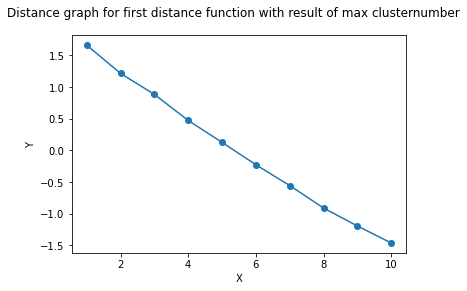

In [107]:
fig = plt.figure()
fig.suptitle('Distance graph for first distance function with result of max clusternumber')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.scatter(clusterList,normalizedDataNumpy)
plt.plot(clusterList, normalizedDataNumpy)
plt.savefig('ellbowcurve.pdf')